In [22]:
%load_ext autoreload
%matplotlib inline
%autoreload 2

from IPython import display
import torch
from torch import nn, optim
from torch.autograd.variable import Variable
from torchvision import transforms, datasets
import os
import numpy as np
import errno
import torchvision.utils as vutils
from IPython import display
from matplotlib import pyplot as plt
import torch
import h5py
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
from sklearn.model_selection import train_test_split
expression_small = np.load("/content/gdrive/My Drive/Colab Notebooks/expression_small.npy")

In [0]:
## Removing genes with 0 expression
mask = np.sum(expression_small,axis=0)>0
expression_small[:,mask]
measurements = 300
num_genes = expression_small.shape[1]

## Simulating random composite measurements
A = np.random.normal(size=(measurements,num_genes))
compressed_mes = np.dot(A,expression_small.T).T
X_train, X_test,y_train, y_test = train_test_split(compressed_mes,expression_small,test_size=0.2)

# Normalize training measurements
X_train_std = np.std(X_train,axis=0)
X_train_mean = np.mean(X_train,axis=0)
X_train = np.divide(X_train - X_train_mean,X_train_std)

# Normalize testing measurements
X_test_mean = np.mean(X_test,axis=0)
X_test_std = np.std(X_test,axis=0)
X_test = np.divide(X_test - X_test_mean,X_test_std)

# Normalize y_train data
y_train_std = np.std(y_train,axis=0)
y_train_std[y_train_std==0] = 1
y_train_mean = np.mean(y_train,axis=0)
y_train = np.divide(y_train - y_train_mean,y_train_std)

In [0]:
train_actual = np.load("/content/gdrive/My Drive/Colab Notebooks/SMAF_gene_actual_train_100.npy").T
train_pred = np.load("/content/gdrive/My Drive/Colab Notebooks/SMAF_gene_pred_train_100.npy").T
num_genes = train_actual.shape[1]

In [0]:
test_actual = np.load("/content/gdrive/My Drive/Colab Notebooks/SMAF_gene_actual_test_100.npy").T
test_pred = np.load("/content/gdrive/My Drive/Colab Notebooks/SMAF_gene_pred_test_100.npy").T

In [115]:
import scipy
scipy.stats.pearsonr(train_actual.flatten(),train_pred.flatten())

(0.9041418454534761, 0.0)

In [0]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        n_features = num_genes
        n_out = num_genes
        
        self.hidden0 = nn.Sequential(
            nn.Linear(n_features, 300),
            nn.ReLU(0.2)
        )
        self.hidden1 = nn.Sequential(            
            nn.Linear(300, 300),
            nn.ReLU(0.2)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(300, 300),
            nn.ReLU(0.2)
        )
        self.hidden3 = nn.Sequential(
            nn.Linear(300, 300),
            nn.ReLU(0.2)
        )
        
        self.out = nn.Sequential(
            nn.Linear(300, n_out)
            # nn.Sigmoid()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.hidden3(x)
        x = self.out(x)
        return x

In [0]:
# discriminator = DiscriminatorNet()
net = Net()
if torch.cuda.is_available():
    # discriminator.cuda()
    net.cuda()

In [0]:
X_train = torch.from_numpy(train_pred.astype(float)).cuda().float()
Y_train = torch.from_numpy(train_actual.astype(float)).cuda().float()

In [0]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.0001,weight_decay=1.0)
criterion = nn.MSELoss()

In [130]:
import scipy
import math
for epoch in range(4000):  # loop over the dataset multiple times
    running_loss = 0.0
    total_correlation = 0.0
    count = 0
    # loss = torch.tensor(0).cuda()
    optimizer.zero_grad()
    outputs=net(X_train)
    loss = criterion(outputs,Y_train)
    loss.backward()
    optimizer.step()
    if epoch % 200 == 0:
      print("epoch:",epoch)
      print("loss",loss.item())

epoch: 0
loss 2053490.75
epoch: 200
loss 468940.8125
epoch: 400
loss 355413.0
epoch: 600
loss 312160.28125
epoch: 800
loss 287517.46875
epoch: 1000
loss 271837.0625
epoch: 1200
loss 260699.40625
epoch: 1400
loss 252017.453125
epoch: 1600
loss 244976.640625
epoch: 1800
loss 238865.828125
epoch: 2000
loss 233718.421875
epoch: 2200
loss 228980.75
epoch: 2400
loss 224816.515625
epoch: 2600
loss 221136.203125
epoch: 2800
loss 217453.859375
epoch: 3000
loss 214061.578125
epoch: 3200
loss 211107.328125
epoch: 3400
loss 208184.796875
epoch: 3600
loss 205471.140625
epoch: 3800
loss 202849.875


In [131]:
out = net(X_train).cpu().data.numpy()
y_nump = Y_train.cpu().data.numpy()
scipy.stats.pearsonr(out.flatten(),y_nump.flatten())

(0.9448718931146857, 0.0)

In [0]:
X_test = torch.from_numpy(test_pred.astype(float)).cuda().float()
Y_test = torch.from_numpy(test_actual.astype(float)).cuda().float()
out = net(X_test).cpu().data.numpy()

In [133]:
y_nump = Y_test.cpu().data.numpy()
scipy.stats.pearsonr(out.flatten(),y_nump.flatten())

(0.873217216423883, 0.0)

In [134]:
scipy.stats.pearsonr(test_pred.flatten(),test_actual.flatten())

(0.8908292668055353, 0.0)

In [135]:
scipy.stats.pearsonr(train_pred.flatten(),train_actual.flatten())

(0.9041418454534761, 0.0)

In [136]:
out_new = scipy.spatial.distance.pdist(out, metric='euclidean')

y_test_new = scipy.spatial.distance.pdist(y_nump, metric='euclidean')

pearson_corr = scipy.stats.pearsonr(out_new, y_test_new)

print(pearson_corr[0])

0.9781277044483838


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")


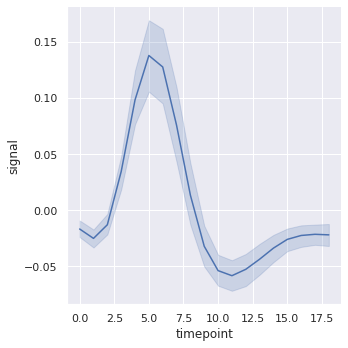

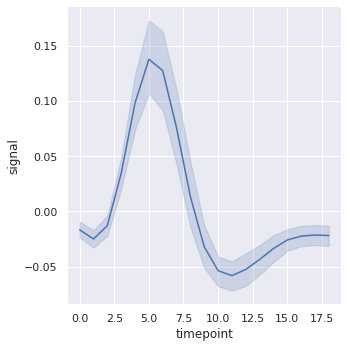

In [140]:
fmri = sns.load_dataset("fmri")
sns.relplot(x="timepoint", y="signal", kind="line", data=fmri);
sns.relplot(x="timepoint", y="signal", kind="line", data=fmri);

In [139]:
fmri

,subject,timepoint,event,region,signal
0,s13,18,stim,parietal,-0.017552
1,s5,14,stim,parietal,-0.080883
2,s12,18,stim,parietal,-0.081033
3,s11,18,stim,parietal,-0.046134
4,s10,18,stim,parietal,-0.037970
...,...,...,...,...,...
1059,s0,8,cue,frontal,0.018165
1060,s13,7,cue,frontal,-0.029130
1061,s12,7,cue,frontal,-0.004939
1062,s11,7,cue,frontal,-0.025367


In [0]:
measurements = []
model = []
pearson_correlation = []
similarity = []

In [0]:
correlations = [0.8198849189,	0.8039869685,	0.9078646212,	0.9168363606,	0.9302707147,
0.3194052148,	0.3640685641,	0.6293018891,	0.7266775068,	0.8206104938,
0.5739562266,	0.7438889925,	0.8737898446,	0.8708718227,	0.9062292107,
0.8250898497,	0.8642241279,	0.9058143519,	0.915790424,	0.9294108818,
0.7092876103,	0.7024535677,	0.7591409209,	0.7570232109,	0.7612412582,
0.765,	0.859,	0.891,	0.922,	0.932]

In [0]:
#distance
correlations = [0.9206217064,	0.8968443524,	0.9808595461,	0.9757108667,	0.9864055323,
0.9475235138,	0.9617371293,	0.9778237935,	0.9839415177,	0.9879192679,
0.9325188687,	0.9581053932,	0.9808987745,	0.9835821734,	0.9858844077,
0.9532529172,	0.959792942,	0.9749566208,	0.9837903365,	0.9820061769,
0.7852672818,	0.9105540552,	0.9250764004,	0.956098387,	0.9574802596,
0.905,	0.971,	0.974,	0.981,	0.9939]

In [0]:
smaf = ["SMAF" for i in range(0,5)]
SVD = ["SVD" for i in range(0,5)]
K_SVD = ["K-SVD" for i in range(0,5)]
S_NMF = ["S-NMF" for i in range(0,5)]
NN = ["NN" for i in range(0,5)]
NN_SMAF = ["NN+SMAF" for i in range(0,5)]
# smaf.append(SVD).append(K_SVD).append(S_NMF).append(NN).append(NN_SMAF)





In [0]:
models = smaf + SVD + K_SVD + S_NMF + NN + NN_SMAF

In [62]:
meas = [20,50,100,200,300] +[20,50,100,200,300]+[20,50,100,200,300]+[20,50,100,200,300]+[20,50,100,200,300]+[20,50,100,200,300]
meas
# [meas + meas for i in range(0,4)]

[20,
 50,
 100,
 200,
 300,
 20,
 50,
 100,
 200,
 300,
 20,
 50,
 100,
 200,
 300,
 20,
 50,
 100,
 200,
 300,
 20,
 50,
 100,
 200,
 300,
 20,
 50,
 100,
 200,
 300]

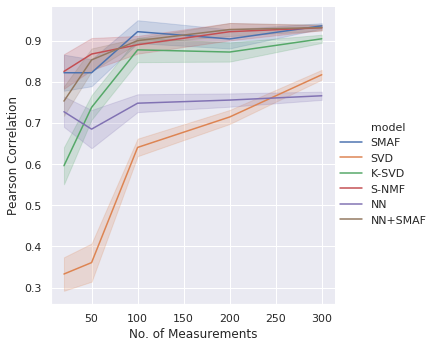

In [64]:
total_corr = correlations+total_corr
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
d = {"Pearson Correlation":total_corr,"model":mod,"No. of Measurements":mes}
df = pd.DataFrame(data=d)
sns.set(style="darkgrid")
x=sns.relplot(x="No. of Measurements", y="Pearson Correlation", kind="line",hue="model", data=df,ci="sd");
x.savefig("/content/gdrive/My Drive/Colab Notebooks/correlation.png")

In [101]:
len(total_corr)

80

In [27]:
len(mes)

330

In [24]:
len(total_corr)

330

In [9]:
5%5

0